In [1]:
import pandas as pd
import os
import subprocess
from Comparative_Analysis import Utilities as util
from Bio import AlignIO
from tqdm.auto import tqdm
import re
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

In [2]:
project_dir = 'D:/Project_Data/Project_8'
r_scape_output_loc = project_dir + '/RScape_Run_Thoth_3'
intergenic_regions = util.list_dirs(r_scape_output_loc)

In [3]:
def overlap_metric(positions_1, positions_2):
    if len(positions_1) < len(positions_2):
        a = positions_1
        b = positions_2
    else:
        a = positions_2
        b = positions_1
    num_comparisons = len(a)
    num_overlaps = 0
    for coord_1 in a:
        for coord_2 in b:
            x, y = np.argsort(coord_1+coord_2)[:2] > 1
            if x != y:
                num_overlaps += 1
                break
    return 1 - num_overlaps / num_comparisons

In [4]:
ids =  util.list_dirs(r_scape_output_loc)
len(ids)

1821

In [5]:
overlap_metric([[0,100],[2000,3000]], [[40,50],[250,450],[0,1]])

0.5

In [6]:
positions_list = []
for id in ids:
    locus = id
    if os.path.isfile(r_scape_output_loc + '/' + id + '/rscape_3.cacofold.power'):
        with open(r_scape_output_loc + '/' + id + '/rscape_3.cacofold.power', 'r') as f:
            positions = []
            for l in f:
                if 'BPAIRS observed' in l:
                    if int(l.split('covary ')[1]) > 10:
                        positions = []
                        with open(r_scape_output_loc + '/' + id + '/summary.txt', 'r') as g:
                             for l in g:
                                if not(l[0] == '#'): 
                                    a = l.split()
                                    if a[16] == '!':
                                        if a[0] == 'NC_000962.3':
                                            positions.append((min(int(a[7]),int(a[8])), max(int(a[7]),int(a[8]))))
        if len(positions)>0:
            positions = set(positions)
            positions_list.append((locus, positions))
    

In [7]:
distance_matrix = np.zeros((len(positions_list), len(positions_list)))
for i, (locus, positions) in enumerate(positions_list):
    for j, (locus_2, positions_2) in enumerate(positions_list):
        distance_matrix[i,j] = overlap_metric(positions, positions_2)

In [8]:
clustering = AgglomerativeClustering(affinity="precomputed",  linkage = 'average', distance_threshold = 0.2, n_clusters = None).fit_predict(distance_matrix)
clustering

array([76, 49, 75, 22, 74, 73, 72, 97, 71, 82,  4,  4, 22, 70, 69, 81, 46,
       46, 22, 46, 46, 16, 68, 16, 66, 65,  4,  4,  4, 85, 46,  9, 46, 84,
       64, 63, 62, 46, 61, 60, 59,  4, 58, 57, 46, 56, 10, 55,  2, 54, 86,
       46,  3, 53, 52, 46, 46, 51, 38, 46, 22, 50, 24, 48, 95, 10,  4, 46,
       46, 46, 94,  5, 46,  1,  0,  7, 46, 93, 46, 91, 15,  2, 21,  2, 89,
       87, 46, 42, 46, 10,  4,  4, 83, 40,  4, 79,  6, 96, 37,  4, 36, 35,
       34, 67,  6, 46, 38, 15, 30, 46, 46,  4, 46,  9, 46, 46, 46,  1,  2,
        1, 46,  4, 18, 10, 46,  0, 18, 46, 46, 28, 27, 92, 94,  8,  8,  1,
       46,  7, 46, 26, 46, 25, 46,  7, 80, 46,  5,  8, 45, 46,  7, 47,  7,
        4, 88, 41, 39,  7, 46, 46, 90,  9,  2, 46, 17, 33, 44,  3, 46, 29,
       46,  4, 13, 46, 46, 46, 12, 23, 43, 19, 77, 46,  4, 46, 31, 46, 11,
        2, 21, 46, 14, 46,  4,  7, 20, 32,  8, 78], dtype=int64)

In [9]:
max(clustering)

97

In [10]:
cluster_hits = []
num_clusters = max(clustering) + 1
for i in range(num_clusters):
    num_coords = 0
    num_members = 0
    members = []
    
    for j, clust in enumerate(clustering):
        if clust == i:
            num_members +=1
            members.append(positions_list[j][0])
            num_coords += len(positions_list[j][1])
            co_ords = positions_list[j][1]        #  Just bring back last set as illustration 
        
    cluster_hits.append([i, num_coords/num_members, num_members, members, co_ords])

In [12]:
[x for x in cluster_hits if 'Rv3217c' in x[3]]

[[4,
  25.176470588235293,
  17,
  ['MTB000141',
   'MTB000150',
   'Rv0480c',
   'Rv0487',
   'Rv0504c',
   'Rv0823c',
   'Rv1173',
   'Rv1668c',
   'Rv1682',
   'Rv1729c',
   'Rv1866',
   'Rv2196',
   'Rv2405',
   'Rv2945c',
   'Rv3217c',
   'Rv3401',
   'Rv3680'],
  {(577284, 577366),
   (577400, 577482),
   (595311, 595392),
   (746355, 746431),
   (917654, 917736),
   (1267182, 1267264),
   (1281935, 1282019),
   (1443412, 1443484),
   (1895354, 1895435),
   (1955560, 1955637),
   (2068987, 2069067),
   (2074435, 2074515),
   (2074547, 2074627),
   (2115673, 2115753),
   (2372435, 2372516),
   (2401846, 2401928),
   (2461325, 2461406),
   (2703958, 2704033),
   (3351149, 3351226),
   (3594262, 3594342),
   (3594374, 3594454),
   (3691008, 3691090),
   (3820455, 3820507),
   (3820508, 3820589),
   (4053023, 4053100),
   (4053134, 4053211),
   (4053245, 4053322),
   (4053356, 4053433),
   (4053467, 4053544),
   (4087474, 4087555),
   (4110676, 4110758),
   (4120974, 4121055),
   (42

In [20]:
[x for x in cluster_hits if x[2]>5]

[[2,
  20.833333333333332,
  6,
  ['Rv0949', 'Rv1466', 'Rv1531', 'Rv2359', 'Rv3136A', 'Rv3547'],
  {(177231, 177292),
   (742569, 742630),
   (1060583, 1060644),
   (1458213, 1458274),
   (1653589, 1653650),
   (1733043, 1733107),
   (1833381, 1833442),
   (1875232, 1875292),
   (2068899, 2068959),
   (2642071, 2642133),
   (2768197, 2768259),
   (2850948, 2851011),
   (3037376, 3037438),
   (3156097, 3156159),
   (3317541, 3317606),
   (3372495, 3372555),
   (3503315, 3503376),
   (3809376, 3809437),
   (3953337, 3953398),
   (3954259, 3954320),
   (3987313, 3987374),
   (4078006, 4078067),
   (4101160, 4101227),
   (4317970, 4318031)}],
 [4,
  25.176470588235293,
  17,
  ['MTB000141',
   'MTB000150',
   'Rv0480c',
   'Rv0487',
   'Rv0504c',
   'Rv0823c',
   'Rv1173',
   'Rv1668c',
   'Rv1682',
   'Rv1729c',
   'Rv1866',
   'Rv2196',
   'Rv2405',
   'Rv2945c',
   'Rv3217c',
   'Rv3401',
   'Rv3680'],
  {(577284, 577366),
   (577400, 577482),
   (595311, 595392),
   (746355, 746431),
 

In [60]:
sns.barplot(x = "Cluster", y = "Number", data = a)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [56]:
a

,Cluster,Number
0,1,69
1,3,26
2,4,51
3,7,17
4,9,27
5,10,36
6,12,11
7,19,43
8,20,65
9,39,47


<AxesSubplot:ylabel='Count'>

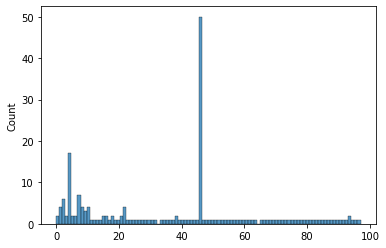

In [13]:
sns.histplot(data = clustering, bins = 100)